# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [248]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Helper functions
Set of helper functions

In [191]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [228]:
class Config():
    training_dir = "./data/pills/training/"
    testing_dir = "./data/pills/testing/"
    train_batch_size = 64
    train_number_epochs = 100

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [229]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        #img0 = img0.convert("L")
        #img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32)), torch.from_numpy(np.array([int(img0_tuple[1])],dtype=np.float32)),torch.from_numpy(np.array([int(img1_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [230]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [231]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

In [232]:
img0_tuple = random.choice(folder_dataset.imgs)

In [233]:
img0_tuple

('./data/pills/training/p103/4733.jpeg', 2)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

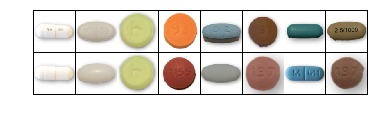

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


In [234]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [235]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 12, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(12),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(12, 12, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(12),


            nn.ReflectionPad2d(1),
            nn.Conv2d(12, 24, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(24),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(24*100*100, 20),
            nn.ReLU(inplace=True),

            nn.Linear(20, 20),
            nn.ReLU(inplace=True),

            nn.Linear(20, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [236]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=0.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [237]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [238]:
net = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [239]:
counter = []
loss_history = [] 
iteration_number= 0

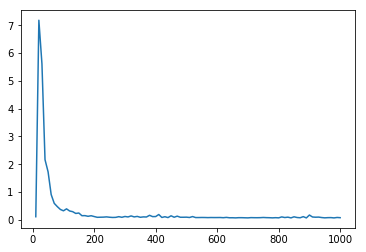

In [240]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label, _, _ = data
        img0, img1 , label = img0, img1 , label
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            #print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

tensor([[0.]]) tensor([[4.]])


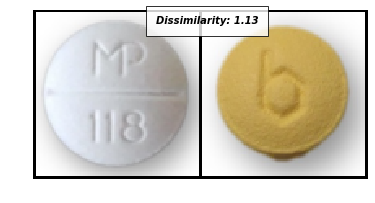

In [241]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=False)
dataiter = iter(test_dataloader)
x0,_,_,class0, _ = next(dataiter)

for i in range(1):
    _,x1,_, _, class1 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    print(class0, class1)
    
    output1,output2 = net(Variable(x0),Variable(x1))
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))



In [252]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=False)

cols = ['class0','class1', 'output', 'dissimilarity']
lst = []

for i_batch, sample_batched in enumerate(test_dataloader):
    x0 = sample_batched[0]
    class0 = sample_batched[3]
    for i_batch, sample_batched in enumerate(test_dataloader):
        x1 = sample_batched[1]
        class1 = sample_batched[4]
        concatenated = torch.cat((x0,x1),0)
        output1,output2 = net(Variable(x0),Variable(x1))
        euclidean_distance = F.pairwise_distance(output1, output2)
        if class0.item() == class1.item():
            image_tup = 0
        else:
            image_tup = 1
        lst.append([class0.item(), class1.item(), image_tup, euclidean_distance.item()])
        #print(class0.item(), class1.item(), image_tup, euclidean_distance.item())

        
df = pd.DataFrame(lst, columns=cols)

In [253]:
df.head(n=5)

,class0,class1,output,dissimilarity
0,0.0,0.0,0,0.806265
1,0.0,2.0,1,0.652706
2,0.0,4.0,1,0.378162
3,0.0,1.0,1,0.175474
4,0.0,0.0,0,2.009080


In [254]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df['output'].value_counts()

1    502
0    123
Name: output, dtype: int64

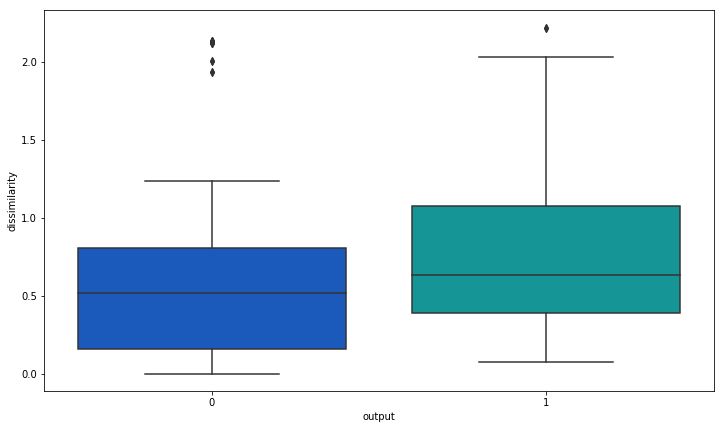

In [255]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='output',y='dissimilarity',data=df,palette='winter')

In [256]:
#rand = np.random.randint(2, size=len(df))
#df['random_guess'] = rand.tolist()
#df

In [257]:
dissimilarity_score = np.arange(0.0,max(df['dissimilarity']), 0.01)
cols = ['dissimilarity_score', 'accuracy', 'accuracy_random']
lst = []

for i in dissimilarity_score:
    df['prediction'] = 0
    df['prediction'][df['dissimilarity'] >= i] = 1
   
    df['correct'] = 0
    df['correct'][df['prediction']  == df['output']] = 1
    
    rand = np.random.randint(2, size=len(df))
    df['random_guess'] = rand.tolist()
    df['correct_guess'] = 0
    df['correct_guess'][df['random_guess'] == df['output']] = 1
    
    acc = sum(df['correct']) / len(df)
    acc_guess = sum(df['correct_guess']) / len(df)
    lst.append([i, acc, acc_guess])

df = pd.DataFrame(lst, columns=cols)
df

,dissimilarity_score,accuracy,accuracy_random
0,0.00,0.8032,0.4992
1,0.01,0.8384,0.5088
2,0.02,0.8384,0.5136
3,0.03,0.8384,0.5104
4,0.04,0.8384,0.4992
5,0.05,0.8384,0.5168
6,0.06,0.8384,0.5024
7,0.07,0.8384,0.5088
8,0.08,0.8368,0.4672
9,0.09,0.8368,0.5104
